<a href="https://colab.research.google.com/github/Randhir123/quant/blob/main/Predicting_short_term_market_trends_across_different_asset_classes_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting short-term market trends across different asset classes using Deep Learning

In this notebook, we'll develop a Deep Learning model that tries to predict
short-term market trends across different asset classes. Then, we will test the
out-of-sample performance of different asset allocation strategies based on the
predictions of the model.

Let's import required packages to begin with.

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras import Sequential
from keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler

We'll download the prices of different securities from Yahoo Finance and perform EDA to understand the data.

In Step 2, we'll develop an LSTM model for each of the security in our portfolio to predict it's 25-day return.

Finally, in Step 3, we'll develop a single LSTM model with multiple outputs to predict 25-day return of all the securities.

##Step 1

### Download the data

In this case we will work with 5 different ETFs, each a major
representative of their asset class:

- Equity → SPDR S&P500 ETF. Symbol: "SPY"
- Fixed Income → iShares 20+ Year Treasury Bond ETF. Symbol: "TLT"
- Cash-like → iShares 1-3 Year Treasury Bond ETF. Symbol: "SHY"
- Precious metals (Gold) SPDR Gold Shares. Symbol: "GLD"
- Crude Oil → Invesco DB Oil Fund. Symbol: "DBO"

In [ ]:
tickers = ['SPY', 'TLT', 'SHY', 'GLD', 'DBO']
prices = yf.download(tickers, start='2018-01-01', end='2022-12-30')
prices.head()

[*********************100%%**********************]  5 of 5 completed


Price      Adj Close                                                 Close  \
Ticker           DBO         GLD        SHY         SPY         TLT    DBO   
Date                                                                         
2018-01-02  9.376728  125.150002  75.393471  242.319336  107.934761  10.19   
2018-01-03  9.579170  124.820000  75.393471  243.852097  108.450783  10.41   
2018-01-04  9.597575  125.459999  75.357498  244.879852  108.433594  10.43   
2018-01-05  9.551564  125.330002  75.357498  246.511703  108.123970  10.38   
2018-01-08  9.606776  125.309998  75.357498  246.962524  108.055138  10.44   

Price                                                      ...   Open  \
Ticker             GLD        SHY         SPY         TLT  ...    DBO   
Date                                                       ...          
2018-01-02  125.150002  83.820000  268.769989  125.489998  ...  10.20   
2018-01-03  124.820000  83.820000  270.470001  126.089996  ...  10.27   
2018-01-04  125.459999  83.779999  271.609985  126.070000  ...  10.41   
2018-01-05  125.330002  83.779999  273.420013  125.709999  ...  10.35   
2018-01-08  125.309998  83.779999  273.920013  125.629997  ...  10.39   

Price                                                      Volume            \
Ticker             GLD        SHY         SPY         TLT     DBO       GLD   
Date                                                                          
2018-01-02  124.660004  83.849998  267.839996  126.489998  155000  11762500   
2018-01-03  125.050003  83.809998  268.959991  126.000000  216000   7904300   
2018-01-04  124.889999  83.769997  271.200012  125.650002  184600   7329700   
2018-01-05  124.930000  83.769997  272.510010  125.870003  307700   5739900   
2018-01-08  125.199997  83.800003  273.309998  125.989998  183400   3566700   

Price                                    
Ticker          SHY       SPY       TLT  
Date                                     
2018-01-02  1786000  86655700  16238200  
2018-01-03  1040900  90070400   8605100  
2018-01-04   955400  80636400   9217900  
2018-01-05   850600  83524000  10915400  
2018-01-08   597700  57319200   8850600  

[5 rows x 30 columns]

In [ ]:
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2018-01-02 to 2022-12-29
Data columns (total 30 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   (Adj Close, DBO)  1258 non-null   float64
 1   (Adj Close, GLD)  1258 non-null   float64
 2   (Adj Close, SHY)  1258 non-null   float64
 3   (Adj Close, SPY)  1258 non-null   float64
 4   (Adj Close, TLT)  1258 non-null   float64
 5   (Close, DBO)      1258 non-null   float64
 6   (Close, GLD)      1258 non-null   float64
 7   (Close, SHY)      1258 non-null   float64
 8   (Close, SPY)      1258 non-null   float64
 9   (Close, TLT)      1258 non-null   float64
 10  (High, DBO)       1258 non-null   float64
 11  (High, GLD)       1258 non-null   float64
 12  (High, SHY)       1258 non-null   float64
 13  (High, SPY)       1258 non-null   float64
 14  (High, TLT)       1258 non-null   float64
 15  (Low, DBO)        1258 non-null   float64
 16  (Low, GLD)        1258 n

In [ ]:
data = prices['Adj Close']
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2018-01-02 to 2022-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DBO     1258 non-null   float64
 1   GLD     1258 non-null   float64
 2   SHY     1258 non-null   float64
 3   SPY     1258 non-null   float64
 4   TLT     1258 non-null   float64
dtypes: float64(5)
memory usage: 59.0 KB


###EDA

Plot the prices of all the 5 securities.

array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

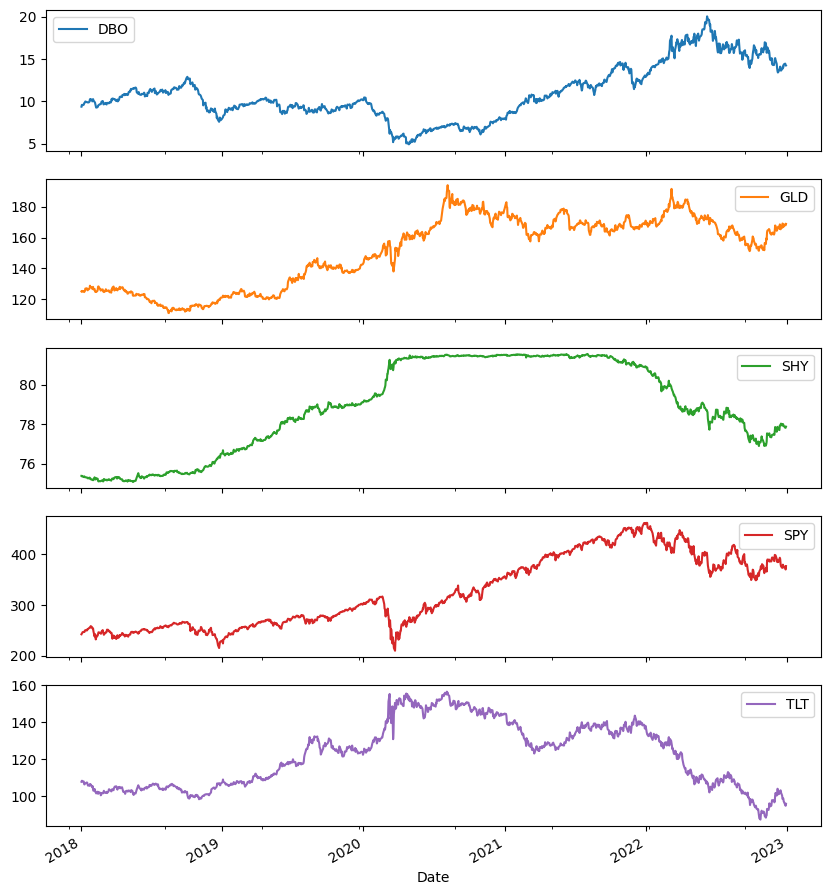

In [ ]:
data.plot(figsize=(10, 12), subplots=True)

Analyse the descriptive statistics of each of the security.

In [ ]:
data.describe().round(2)

Ticker,DBO,GLD,SHY,SPY,TLT
count,1258.00,1258.00,1258.00,1258.00,1258.00
mean,10.91,150.92,78.90,325.57,122.31
std,3.19,22.50,2.29,69.92,17.42
min,4.94,111.10,75.09,209.93,87.49
25%,8.89,125.86,77.06,261.51,106.19
50%,10.21,159.43,78.88,307.30,124.37
75%,12.51,169.35,81.41,390.78,136.95
max,20.03,193.89,81.56,461.61,156.62


Check for stationarity for each series.

In [ ]:
def adfuller_test(series, signif=0.05):
  """
  Perform Augmented Dickey-Fuller to test for Stationarity of the given series
  and print report. Null Hypothesis: Data has unit root and is non-stationary.

  series: time series in pd.Series format
  signif: significance level for P-value to reject Null Hypothesis
  """
  x = adfuller(series, autolag='AIC')

  output = {'Test Statistic': x[0],
            'P-value': x[1],
            'Number of lags': x[2],
            'Number of observations': x[3],
            f'Reject (signif. level {signif})': x[1] < signif }

  for key, val in x[4].items():
    output[f'Critical value {key}'] = val

  return pd.Series(output)

data.apply(lambda x: adfuller_test(x), axis=0)

Ticker,DBO,GLD,SHY,SPY,TLT
Test Statistic,-0.969849,-1.195036,-1.619587,-1.147397,-0.718538
P-value,0.764102,0.675727,0.472946,0.695805,0.841889
Number of lags,7,5,18,10,9
Number of observations,1250,1252,1239,1247,1248
Reject (signif. level 0.05),False,False,False,False,False
Critical value 1%,-3.435592,-3.435584,-3.435639,-3.435605,-3.435601
Critical value 5%,-2.863855,-2.863851,-2.863876,-2.863861,-2.863859
Critical value 10%,-2.568003,-2.568001,-2.568013,-2.568005,-2.568004


The critical value at each significance level is lesser than the statistic. We cannot reject the null hypothesis that the series is non-stationary.

At this point, we have the following data matrix that we'll work with.

In [ ]:
data

Ticker,DBO,GLD,SHY,SPY,TLT
Date,,,,,
2018-01-02,9.376728,125.150002,75.393471,242.319336,107.934761
2018-01-03,9.579170,124.820000,75.393471,243.852097,108.450783
2018-01-04,9.597575,125.459999,75.357498,244.879852,108.433594
2018-01-05,9.551564,125.330002,75.357498,246.511703,108.123970
2018-01-08,9.606776,125.309998,75.357498,246.962524,108.055138
...,...,...,...,...,...
2022-12-22,14.010883,166.759995,77.970100,373.858582,98.889465
2022-12-23,14.355413,167.259995,77.931763,376.009125,97.439713
2022-12-27,14.460686,168.669998,77.826355,374.526306,95.513023


For time-series data, it is prudent to see if there are any trend, seasonality (period of less than 1 year), cyclicity (period of more than 1 year) present. Since the data is collected every day for several years, we'll use a periodicity of 252 trading days in seasonal decomposition.

In [ ]:
def plot_seasonal_decomposition(stock_data, stock_symbol):
    closing_prices = stock_data[stock_symbol]
    result = seasonal_decompose(closing_prices, model='additive', period = 252)

    result.plot()
    plt.suptitle('Seasonal Decomposition')
    plt.tight_layout()
    plt.show()

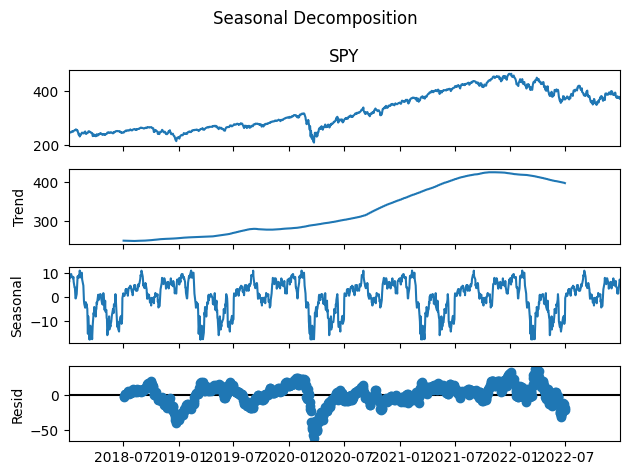

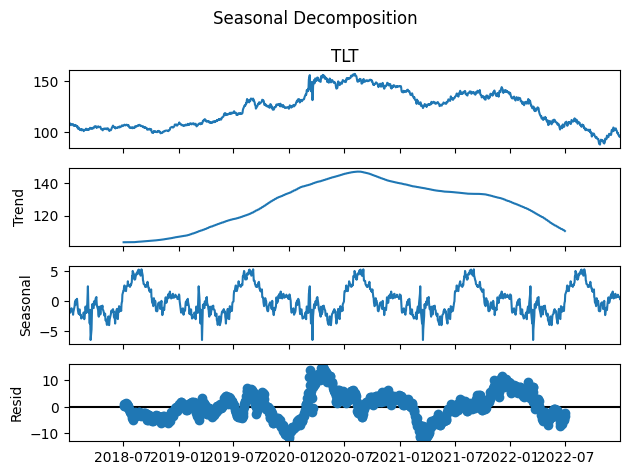

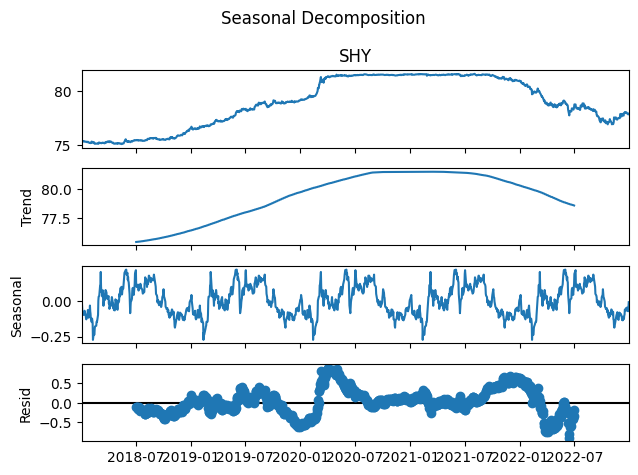

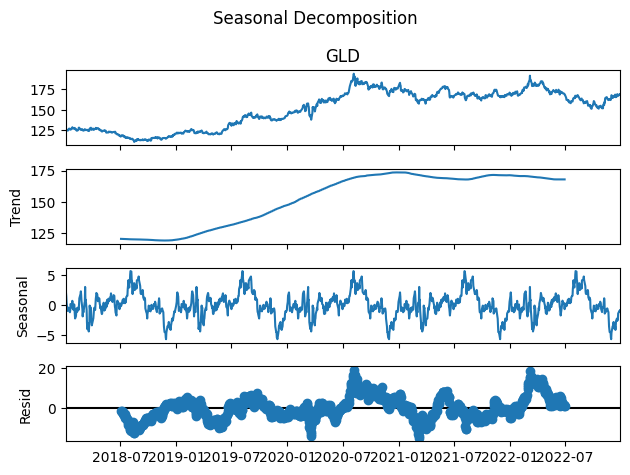

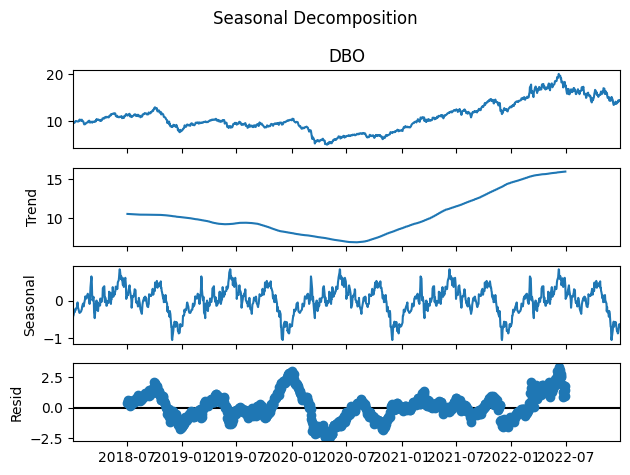

In [ ]:
for ticker in tickers:
  plot_seasonal_decomposition(data, ticker)

As the data is non-stationary, we'll work with daily returns which involves taking differences with consecutive values. Let's explore the daily returns for each asset classes.

In [ ]:
data.pct_change().round(3).head()

Ticker,DBO,GLD,SHY,SPY,TLT
Date,,,,,
2018-01-02,NaN,NaN,NaN,NaN,NaN
2018-01-03,0.022,-0.003,0.0,0.006,0.005
2018-01-04,0.002,0.005,-0.0,0.004,-0.000
2018-01-05,-0.005,-0.001,0.0,0.007,-0.003
2018-01-08,0.006,-0.000,0.0,0.002,-0.001


Mean of the daily returns for each security.

<Axes: xlabel='Ticker'>

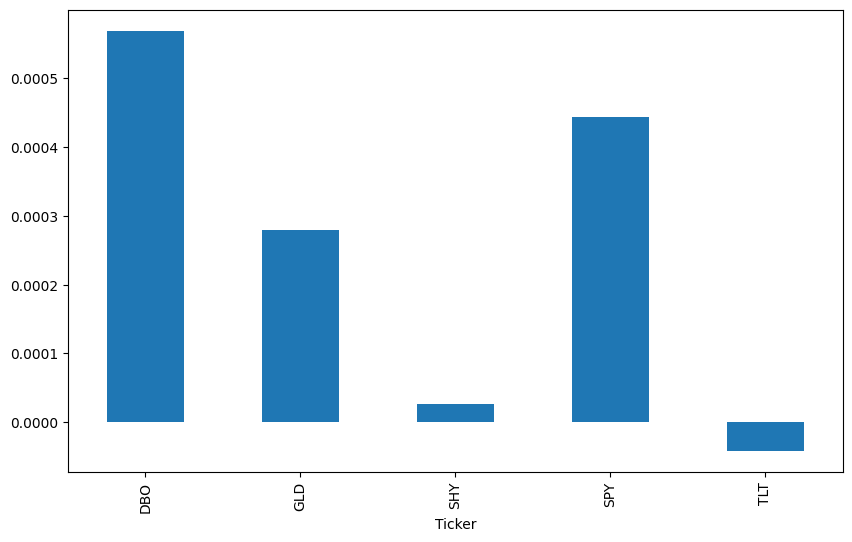

In [ ]:
data.pct_change().mean().plot(kind='bar', figsize=(10, 6))

Taking log of returns is another popular method during EDA as the values are additive. So, let's check the logs of returns.

In [ ]:
rets = np.log(data / data.shift(1))
rets.dropna(inplace=True)

In [ ]:
rets.head().round(3)

Ticker,DBO,GLD,SHY,SPY,TLT
Date,,,,,
2018-01-03,0.021,-0.003,0.0,0.006,0.005
2018-01-04,0.002,0.005,-0.0,0.004,-0.000
2018-01-05,-0.005,-0.001,0.0,0.007,-0.003
2018-01-08,0.006,-0.000,0.0,0.002,-0.001
2018-01-09,0.017,-0.005,-0.0,0.002,-0.013


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

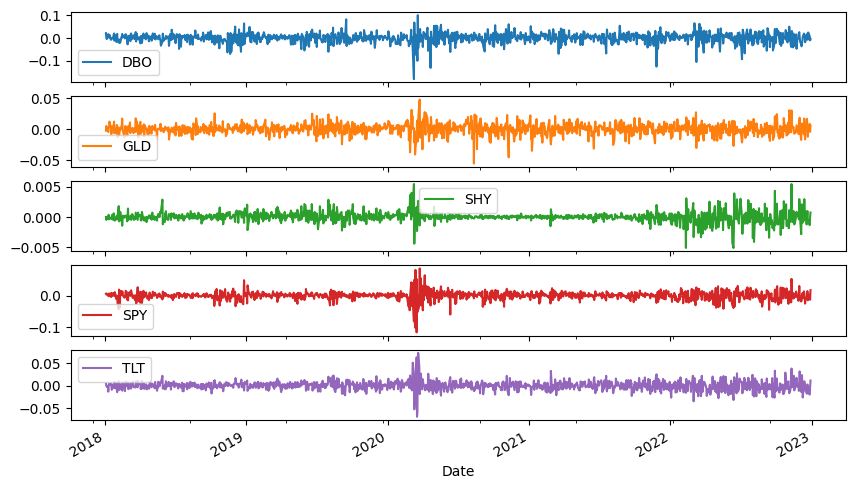

In [ ]:
rets.plot(subplots=True, figsize=(10, 6))

In [ ]:
rets.apply(lambda x: adfuller_test(x), axis=0)

Ticker,DBO,GLD,SHY,SPY,TLT
Test Statistic,-36.908572,-15.417612,-6.670396,-10.848486,-10.603373
P-value,0.0,0.0,0.0,0.0,0.0
Number of lags,0,6,17,8,9
Number of observations,1256,1250,1239,1248,1247
Reject (signif. level 0.05),True,True,True,True,True
Critical value 1%,-3.435567,-3.435592,-3.435639,-3.435601,-3.435605
Critical value 5%,-2.863844,-2.863855,-2.863876,-2.863859,-2.863861
Critical value 10%,-2.567997,-2.568003,-2.568013,-2.568004,-2.568005


Log of returns are now stationarity as the AD Fuller test above shows.

Let's check the cumulative resturns of each security during the period.

<Axes: xlabel='Date'>

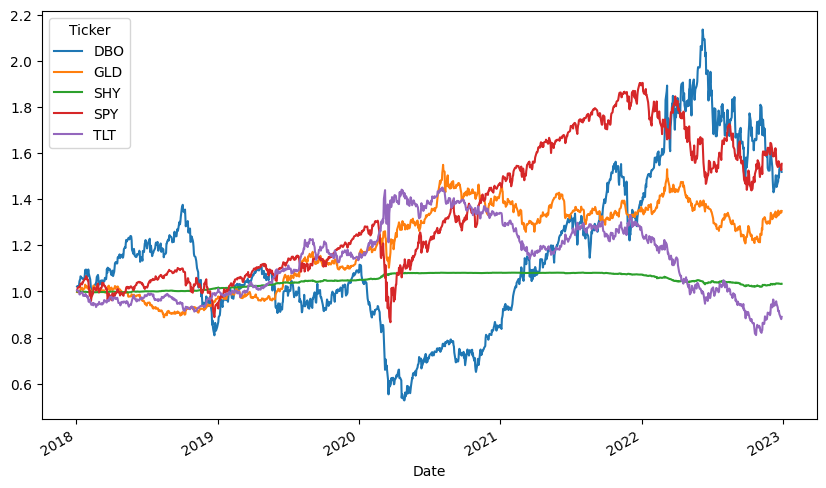

In [ ]:
rets.cumsum().apply(np.exp).plot(figsize=(10, 6))

Next, let's check the correlation among the series. We'll start with scatter plot.

array([[<Axes: xlabel='DBO', ylabel='DBO'>,
        <Axes: xlabel='GLD', ylabel='DBO'>,
        <Axes: xlabel='SHY', ylabel='DBO'>,
        <Axes: xlabel='SPY', ylabel='DBO'>,
        <Axes: xlabel='TLT', ylabel='DBO'>],
       [<Axes: xlabel='DBO', ylabel='GLD'>,
        <Axes: xlabel='GLD', ylabel='GLD'>,
        <Axes: xlabel='SHY', ylabel='GLD'>,
        <Axes: xlabel='SPY', ylabel='GLD'>,
        <Axes: xlabel='TLT', ylabel='GLD'>],
       [<Axes: xlabel='DBO', ylabel='SHY'>,
        <Axes: xlabel='GLD', ylabel='SHY'>,
        <Axes: xlabel='SHY', ylabel='SHY'>,
        <Axes: xlabel='SPY', ylabel='SHY'>,
        <Axes: xlabel='TLT', ylabel='SHY'>],
       [<Axes: xlabel='DBO', ylabel='SPY'>,
        <Axes: xlabel='GLD', ylabel='SPY'>,
        <Axes: xlabel='SHY', ylabel='SPY'>,
        <Axes: xlabel='SPY', ylabel='SPY'>,
        <Axes: xlabel='TLT', ylabel='SPY'>],
       [<Axes: xlabel='DBO', ylabel='TLT'>,
        <Axes: xlabel='GLD', ylabel='TLT'>,
        <Axes: xlabel='SHY',

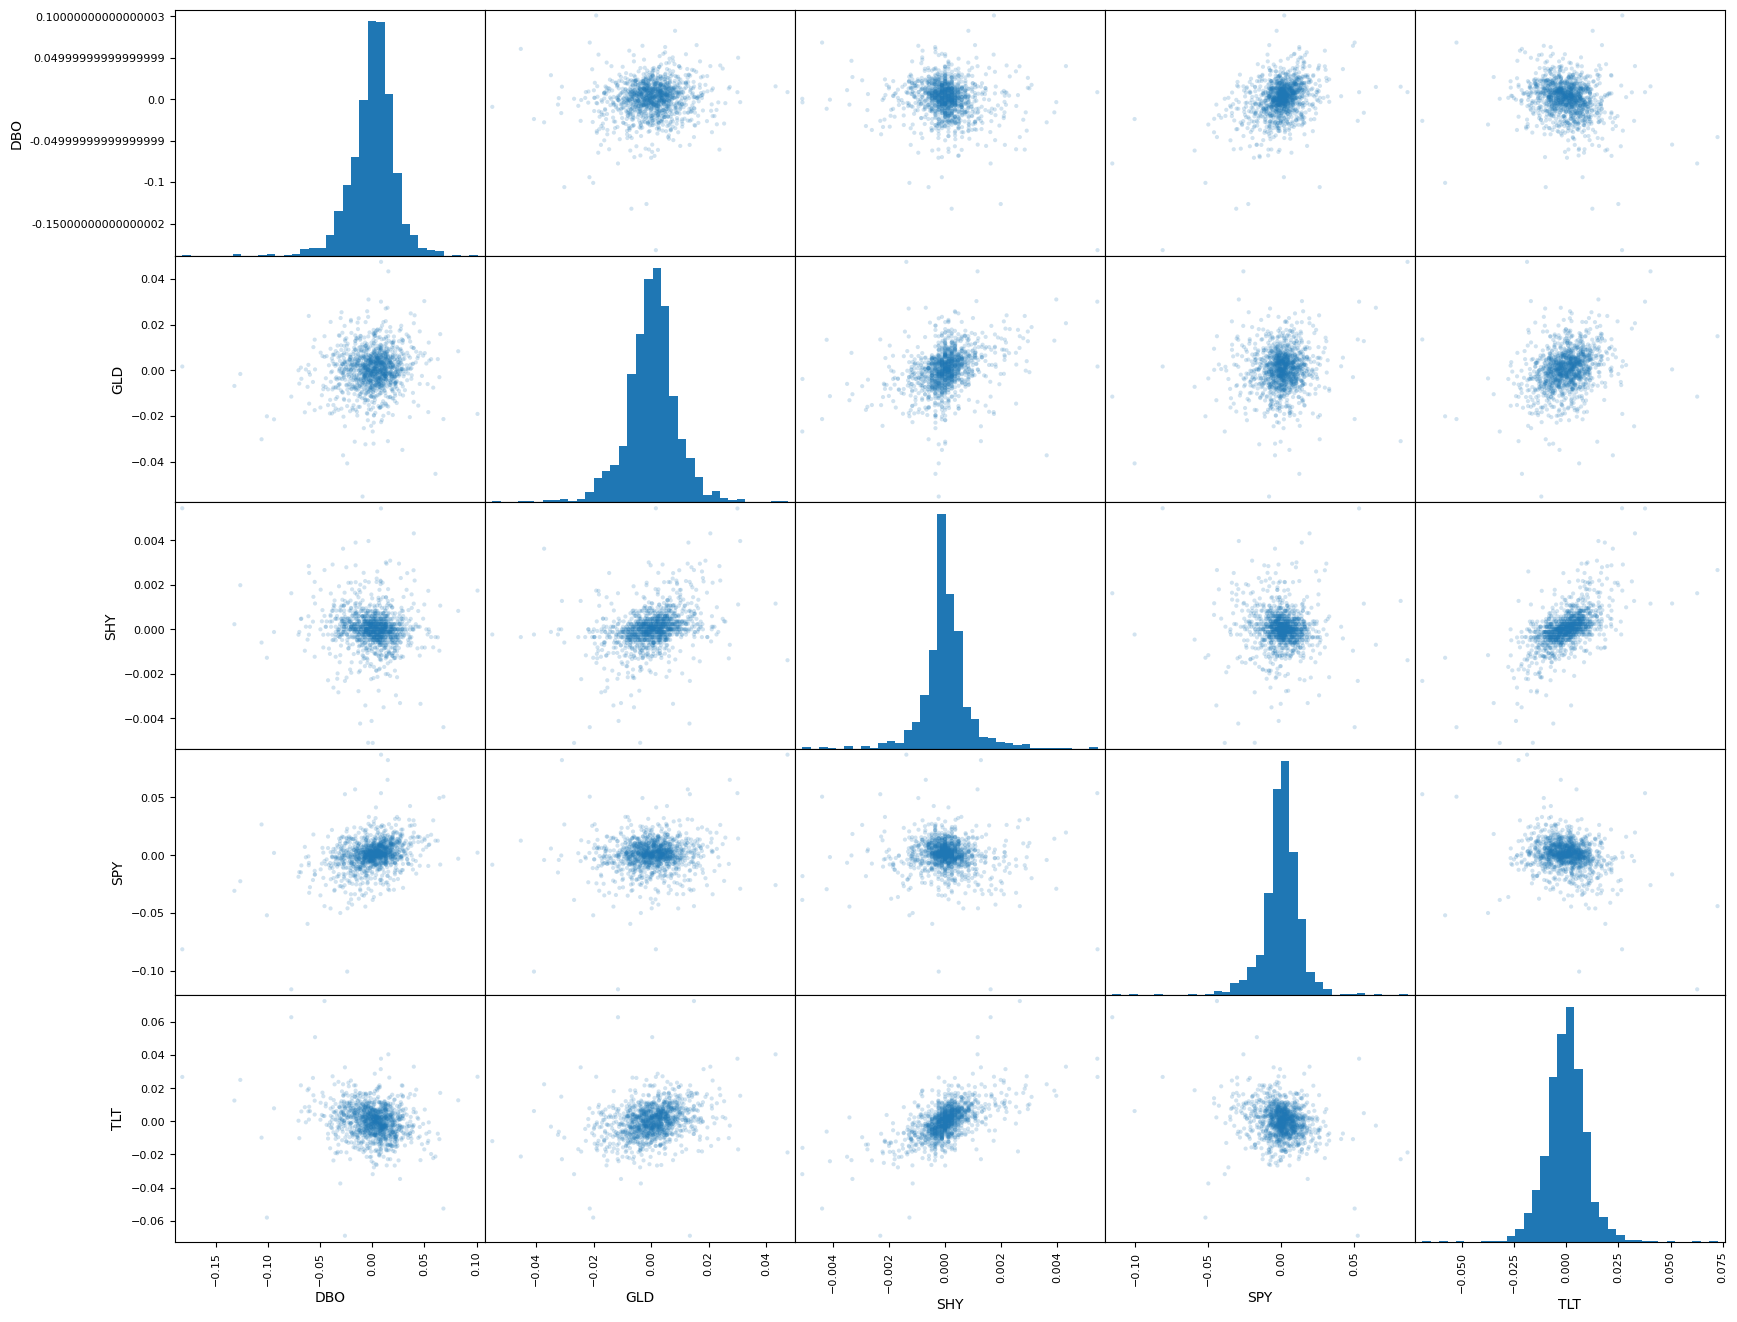

In [ ]:
pd.plotting.scatter_matrix(rets,alpha=0.2,diagonal='hist',hist_kwds={'bins': 35},figsize=(20, 16))

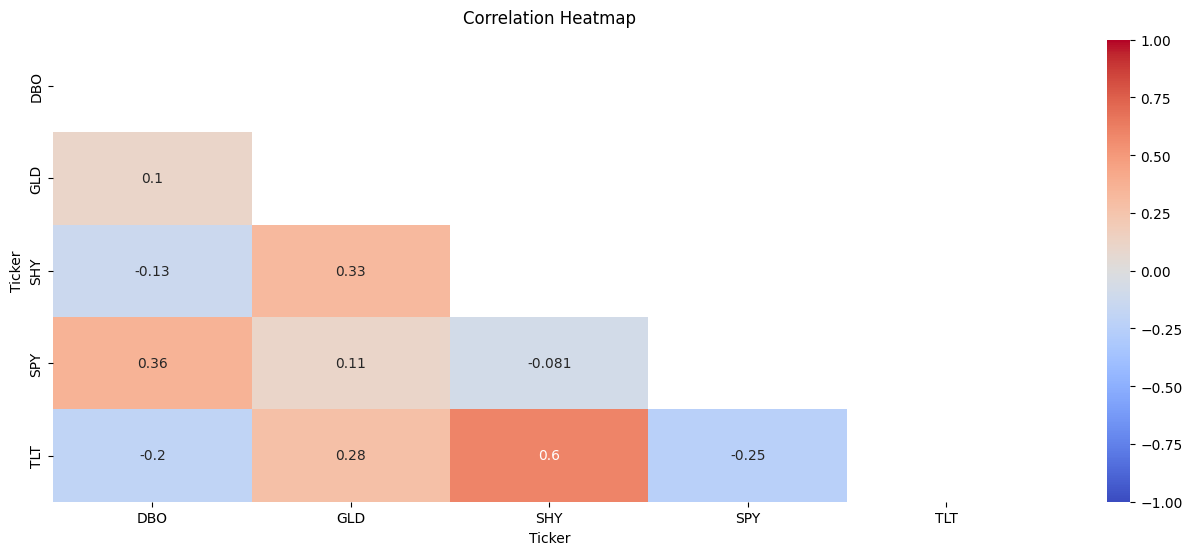

In [ ]:
plt.figure(figsize=(16,6))
mask = np.triu(np.ones_like(rets.corr()))
heatmap = sns.heatmap(rets.corr(), mask=mask, vmin=-1, vmax=1, cmap='coolwarm', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Security returns do not show strong correlation among them. SHY and TLT, both being bond ETFs, show moderate correlation among them.

## Step 2

We'll predict 25-day return of the securities in our portfolio using sequence model - LSTM.

There are two ways we can go about achieving this.
- An LSTM with one output for each of the security
- An LSTM with 5 outputs. One output for each security.

The former requires us to train 5 LSTM separately, whereas the latter with slightly more parameters to train can be trained only once.

###Deep Learning model using recurrent neural networks

Let's review the data for which we want to build a sequence model.

In [ ]:
rets

Ticker,DBO,GLD,SHY,SPY,TLT
Date,,,,,
2018-01-03,0.021360,-0.002640,0.000000,0.006305,0.004769
2018-01-04,0.001920,0.005114,-0.000477,0.004206,-0.000159
2018-01-05,-0.004806,-0.001037,0.000000,0.006642,-0.002860
2018-01-08,0.005764,-0.000160,0.000000,0.001827,-0.000637
2018-01-09,0.017094,-0.004639,-0.000358,0.002261,-0.013463
...,...,...,...,...,...
2022-12-22,-0.007486,-0.012159,-0.000614,-0.014369,-0.000193
2022-12-23,0.024293,0.002994,-0.000492,0.005736,-0.014769
2022-12-27,0.007307,0.008395,-0.001353,-0.003951,-0.019971


What are the features can we extract from this dataset? To predict 25-day return for a security, which will be our target variable, we can train on features - 1-day return, 10-day return and 50-day return.

Let's create these features and add to our dataframe.

In [ ]:
def get_ticker_data(ticker):
  df = rets[ticker].to_frame()
  df[ticker + "_10"] = df[ticker].rolling(10).apply(lambda x: np.prod(1 + x / 100) - 1)
  df[ticker + "_50"] = df[ticker].rolling(50).apply(lambda x: np.prod(1 + x / 100) - 1)
  df[ticker + "_25"] = df[ticker].rolling(25).apply(lambda x: np.prod(1 + x / 100) - 1)
  df[ticker + "25"] = df[ticker + "_25"].shift(-25)
  del df[ticker + "_25"]
  df = df.dropna()

  Xdf, ydf = df.iloc[:, 0:-1], df.iloc[:, -1]
  X = Xdf.astype("float32")
  y = ydf.astype("float32")

  return X, y

Next, what will be the size of each training sample, i.e., how many past days of values we want to use to predict? We will set a rolling window of 30 days.

The size of the input data matrix to be fed to LSTM network then becomes:

    N X D X F

where N = Number of samples,

D = Window size, i.e., number of past samples we want to use to predict a value,

F = Number of features in a sample, here it is 3 (1-day return, 10-day return, 50-day return)


In [ ]:
def train_test_split(X, y):
  train_size = int(len(X) * train_split)
  val_size = int(train_size * val_split)
  test_size = int(len(X) - train_size)

  window_size = 30

  ts = test_size
  split_time = len(X) - ts
  test_time = X.index[split_time + window_size :]

  y_train_set = y[:split_time]
  y_test_set = y[split_time:]

  X_train_set = X[:split_time]
  X_test_set = X[split_time:]

  return X_train_set, X_test_set, y_train_set, y_test_set, test_time

Let's scale all the datasets using MinMax scaler.

In [ ]:
def scale_data(X_train_set, X_test_set, y_train_set, y_test_set):
  scaler_input = MinMaxScaler(feature_range=(-1, 1))
  scaler_input.fit(X_train_set)
  X_train_set_scaled = scaler_input.transform(X_train_set)
  X_test_set_scaled = scaler_input.transform(X_test_set)

  mean_ret = np.mean(y_train_set)

  scaler_output = MinMaxScaler(feature_range=(-1, 1))
  y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
  y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
  scaler_output.fit(y_train_set)
  y_train_set_scaled = scaler_output.transform(y_train_set)

  return X_train_set_scaled, X_test_set_scaled, y_train_set_scaled, y_test_set, scaler_output, mean_ret

In [ ]:
def prepare_data_for_LSTM(window_size, X_train_set_scaled, X_test_set_scaled, y_train_set_scaled, y_test_set):
  X_train = []
  y_train = []

  for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

  X_train, y_train = np.array(X_train), np.array(y_train)

  print("Shape of training data", X_train.shape, y_train.shape)

  X_test = []
  y_test = y_test_set

  for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

  X_test, y_test = np.array(X_test), np.array(y_test)

  print("Shape of test data", X_test.shape, y_test.shape)

  return X_train, y_train, X_test, y_test

Let's build a model with 4 LSTM layers and 3 Dense layers as shown below.

In [ ]:
def build_model(X_train, y_train, n_features):
  model = Sequential()

  model.add(
    LSTM(
        units=units_lstm,
        return_sequences=True,
        activation="tanh",
        input_shape=(X_train.shape[1], n_features),
    )
  )
  model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
  model.add(Dropout(n_dropout, seed=SEED))


  model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
  model.add(Dropout(n_dropout, seed=SEED))


  model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
  model.add(Dropout(n_dropout, seed=SEED))

  model.add(Dense(units=20, activation=act_fun))
  model.add(Dropout(n_dropout, seed=SEED))

  model.add(Dense(units=10, activation=act_fun))
  model.add(Dropout(n_dropout, seed=SEED))

  model.add(Dense(1))

  return model

Let's train our model with early stopping criteria defined to avoid overfitting.

In [ ]:
def train_model(model, X_train, y_train):
  model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
  )

  es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
  )

  # fit the models
  model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
  )

  return model

Once model is created, get predictions from the model and compute the score.

In [ ]:
def R2_campbell(y_true, y_predicted, mean_ret):
  y_predicted = y_predicted.reshape((-1,))
  sse = sum((y_true - y_predicted) ** 2)
  tse = sum((y_true - mean_ret) ** 2)
  r2_score = 1 - (sse / tse)

  return r2_score

def get_predictions(model, X_test, y_test, window_size, scaler_output, mean_ret, test_time):
  prediction = model.predict(X_test)
  prediction = scaler_output.inverse_transform(prediction)
  prediction = prediction.flatten()

  values = np.array(y_test[window_size:])
  values = values.flatten()

  R2_Campbell = R2_campbell(values, prediction, mean_ret)
  print("Out-of-sample R-squared:", R2_Campbell)

  #
  df_predictions = pd.DataFrame(
    {"Date": test_time, "Pred LSTM": prediction, "values": values}
  )
  return df_predictions

In [ ]:
def get_results(df_predictions):
  df_predictions["Positions"] = df_predictions["Pred LSTM"].apply(np.sign)
  df_predictions["Strat_ret"] = (
    df_predictions["Positions"].shift(1) * df_predictions["values"]
  )
  df_predictions["CumRet"] = (
    df_predictions["Strat_ret"].expanding().apply(lambda x: np.prod(1 + x) - 1)
  )
  df_predictions["bhRet"] = (
    df_predictions["values"].expanding().apply(lambda x: np.prod(1 + x) - 1)
  )

  Final_Return = np.prod(1 + df_predictions["Strat_ret"]) - 1
  Buy_Return = np.prod(1 + df_predictions["values"]) - 1

  return (df_predictions, Final_Return, Buy_Return)

The model training and testing scores are shown below.

In [ ]:
window_size = 30
val_split = 0.2
train_split = 0.625
hp_lr = 1e-4

SEED = 42

units_lstm = 50
n_dropout = 0.2
act_fun = "relu"

predictions_dict = {}


for ticker in tickers:

  print(f'Processing {ticker}')

  X, y = get_ticker_data(ticker)
  X_train_set, X_test_set, y_train_set, y_test_set, test_time = train_test_split(X, y)

  n_features = X_train_set.shape[1]
  X_train_set_scaled, X_test_set_scaled, y_train_set_scaled, y_test_set, scaler_output, mean_ret = scale_data(X_train_set, X_test_set, y_train_set, y_test_set)
  X_train, y_train, X_test, y_test = prepare_data_for_LSTM(window_size, X_train_set_scaled, X_test_set_scaled, y_train_set_scaled, y_test_set)

  model = build_model(X_train, y_train, n_features)
  print(model.summary())
  trained_model = train_model(model, X_train, y_train)
  df_predictions = get_predictions(trained_model, X_test, y_test, window_size, scaler_output, mean_ret, test_time)
  predictions_dict[ticker] = get_results(df_predictions)


Processing SPY
Shape of training data (709, 30, 3) (709, 1)
Shape of test data (414, 30, 3) (444, 1)
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 30, 50)            10800     
                                                                 
 lstm_25 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_30 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_26 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_31 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_27 (LSTM)              (None, 50)                20200     
                   

Results for SPY
Strat Return = -5.062878131866455 %
Buy and Hold Return = -0.8044421672821045 %


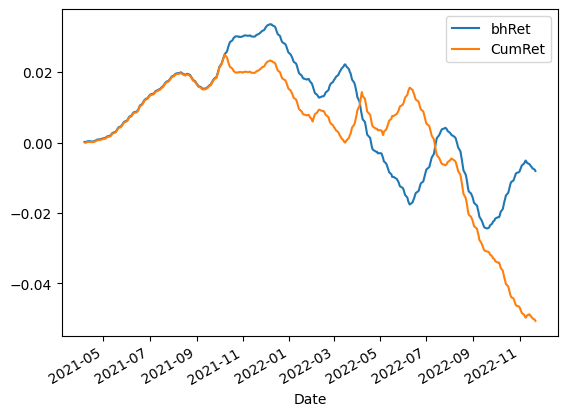

Results for TLT
Strat Return = -6.030398607254028 %
Buy and Hold Return = -6.0344398021698 %


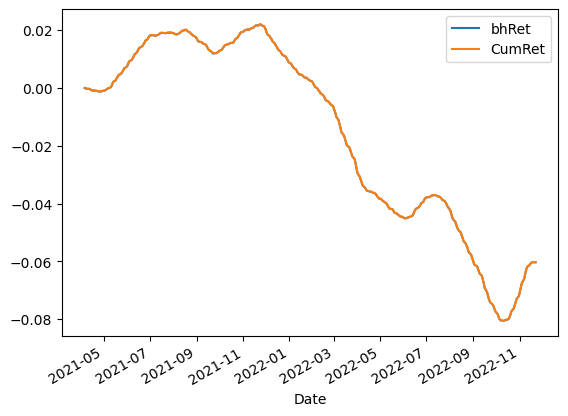

Results for SHY
Strat Return = -1.1459767818450928 %
Buy and Hold Return = -1.1453807353973389 %


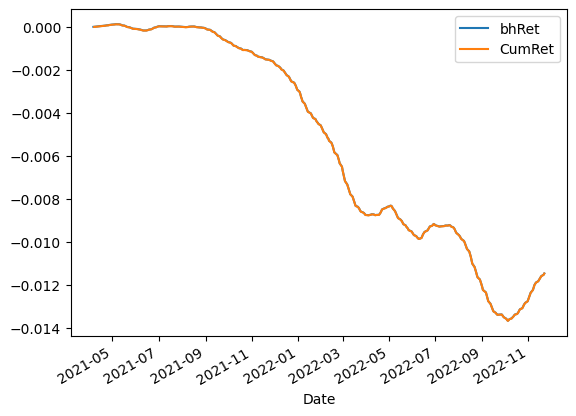

Results for GLD
Strat Return = -0.039827823638916016 %
Buy and Hold Return = 0.013089179992675781 %


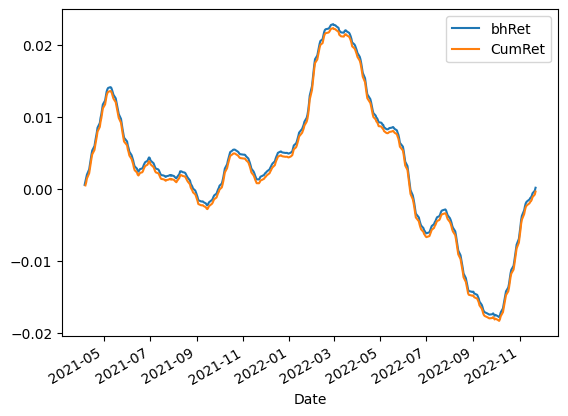

Results for DBO
Strat Return = -8.447021245956421 %
Buy and Hold Return = 7.429170608520508 %


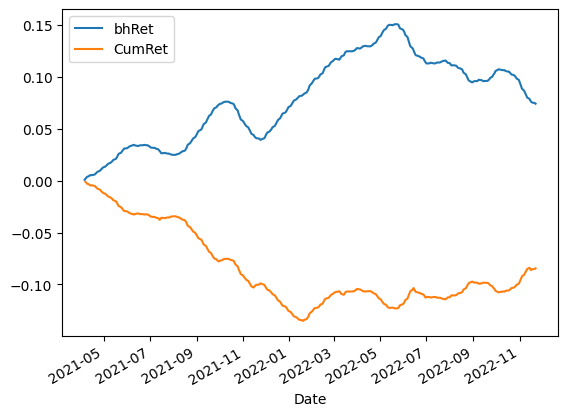

In [ ]:
for ticker, value in predictions_dict.items():
  df_predictions, Final_Return, Buy_Return = value
  print(f'Results for {ticker}')
  print("Strat Return =", Final_Return * 100, "%")
  print("Buy and Hold Return =", Buy_Return * 100, "%")

  ax = plt.gca()
  df_predictions.plot(x="Date", y="bhRet", ax=ax)
  df_predictions.plot(x="Date", y="CumRet", ax=ax)
  plt.show()

## Step 3

### Deep Learning model with multi-output

How do we modify above model to output all the predictions with multiple output LSTM model?

First, we'll create a single dataframe, and stack all the features for each security column-wise.

Next, we create a new LSTM, create an input layer with 15 features (3 features X 5 securities), and output layer with 5 nodes.

In [ ]:
X_portfolio  = pd.DataFrame()
y_portfolio = pd.DataFrame()

for ticker in tickers:
  X, y = get_ticker_data(ticker)
  X_portfolio = pd.concat([X_portfolio, X], axis=1)
  y_portfolio = pd.concat([y_portfolio, y], axis=1)

In [ ]:
def scale_data_multi(X_train_set, X_test_set, y_train_set, y_test_set):
  scaler_input = MinMaxScaler(feature_range=(-1, 1))
  scaler_input.fit(X_train_set)
  X_train_set_scaled = scaler_input.transform(X_train_set)
  X_test_set_scaled = scaler_input.transform(X_test_set)

  mean_ret = np.mean(y_train_set)

  scaler_output = MinMaxScaler(feature_range=(-1, 1))
  y_train_set = y_train_set.values.reshape(len(y_train_set), y_train_set.shape[1])
  y_test_set = y_test_set.values.reshape(len(y_test_set), y_train_set.shape[1])
  scaler_output.fit(y_train_set)
  y_train_set_scaled = scaler_output.transform(y_train_set)

  return X_train_set_scaled, X_test_set_scaled, y_train_set_scaled, y_test_set, scaler_output, mean_ret

In [ ]:
def build_model_multi(X_train, y_train, n_features, n_output):
  model = Sequential()

  model.add(
    LSTM(
        units=units_lstm,
        return_sequences=True,
        activation="tanh",
        input_shape=(X_train.shape[1], n_features),
    )
  )
  model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
  model.add(Dropout(n_dropout, seed=SEED))


  model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh"))
  model.add(Dropout(n_dropout, seed=SEED))


  model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh"))
  model.add(Dropout(n_dropout, seed=SEED))

  model.add(Dense(units=20, activation=act_fun))
  model.add(Dropout(n_dropout, seed=SEED))

  model.add(Dense(units=10, activation=act_fun))
  model.add(Dropout(n_dropout, seed=SEED))

  model.add(Dense(n_output))

  return model

In [ ]:
def get_predictions_multi(model, X_test, y_test, window_size, scaler_output, mean_ret, test_time):
  prediction = model.predict(X_test)
  prediction = scaler_output.inverse_transform(prediction)

  values = np.array(y_test[window_size:])

  i = 0
  df_predictions = {}
  for ticker in tickers:
    print(f'Processing {ticker}')

    R2_Campbell = R2_campbell(values[:, i], prediction[:, i], mean_ret)
    print("Out-of-sample R-squared:", R2_Campbell)

    df_predictions[ticker] = pd.DataFrame(
      {"Date": test_time, "Pred LSTM": prediction[:, i], "values": values[:, i]}
    )
    i = i + 1
  return df_predictions

In [ ]:
n_outputs = 5
X_train_set, X_test_set, y_train_set, y_test_set, test_time = train_test_split(X_portfolio, y_portfolio)

n_features = X_train_set.shape[1]
X_train_set_scaled, X_test_set_scaled, y_train_set_scaled, y_test_set, scaler_output, mean_ret = scale_data_multi(X_train_set, X_test_set, y_train_set, y_test_set)
X_train, y_train, X_test, y_test = prepare_data_for_LSTM(window_size, X_train_set_scaled, X_test_set_scaled, y_train_set_scaled, y_test_set)

model = build_model_multi(X_train, y_train, n_features, n_outputs)
print(model.summary())
trained_model = train_model(model, X_train, y_train)


Shape of training data (709, 30, 15) (709, 5)
Shape of test data (414, 30, 15) (444, 5)
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 30, 50)            13200     
                                                                 
 lstm_45 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_55 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_46 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_56 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_47 (LSTM)              (None, 50)                20200     
                               

13/13 [==============================] - 0s 19ms/step
Processing SPY
Out-of-sample R-squared: -0.08163450823391472
Processing TLT
Out-of-sample R-squared: -0.6420430749933801
Processing SHY
Out-of-sample R-squared: 0.50153975199312
Processing GLD
Out-of-sample R-squared: -0.2967415256732906
Processing DBO
Out-of-sample R-squared: -0.15429078380852723
Results for SPY
Strat Return = -4.814887046813965 %
Buy and Hold Return = -0.8044421672821045 %


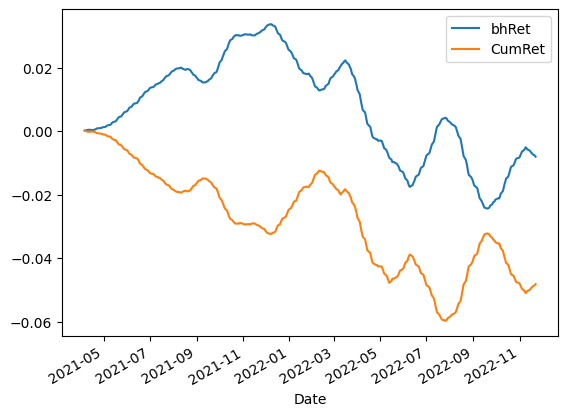

Results for TLT
Strat Return = -6.030398607254028 %
Buy and Hold Return = -6.0344398021698 %


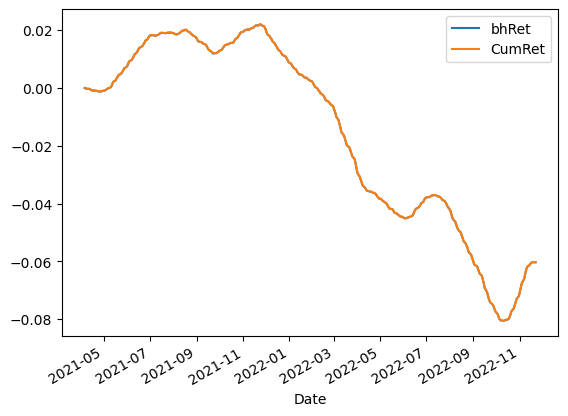

Results for SHY
Strat Return = -1.1459767818450928 %
Buy and Hold Return = -1.1453807353973389 %


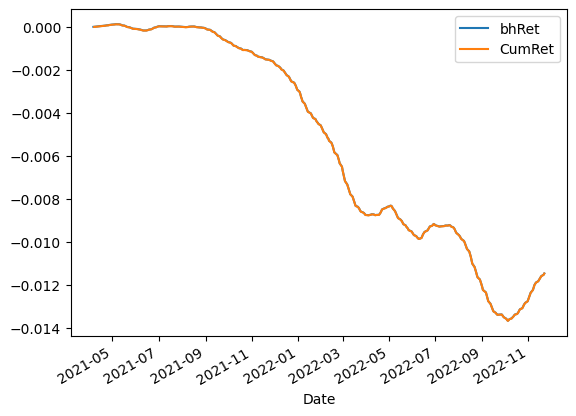

Results for GLD
Strat Return = -0.039827823638916016 %
Buy and Hold Return = 0.013089179992675781 %


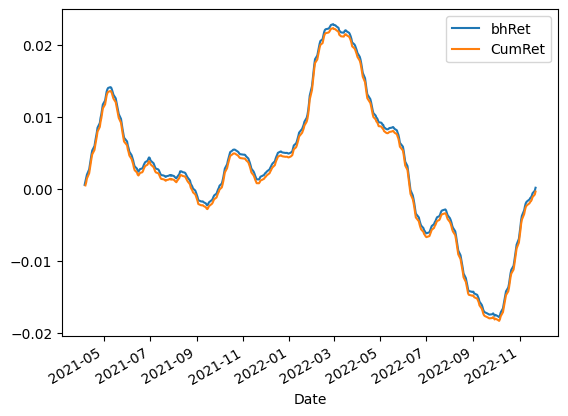

Results for DBO
Strat Return = -5.259817838668823 %
Buy and Hold Return = 7.429170608520508 %


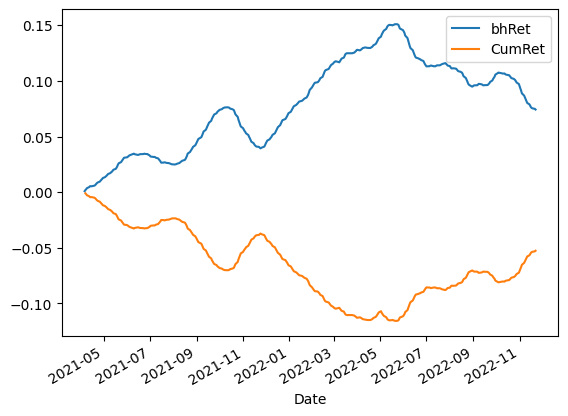

In [ ]:
df_predictions = get_predictions_multi(trained_model, X_test, y_test, window_size, scaler_output, mean_ret, test_time)
predictions_dict = {}
for ticker in tickers:
  predictions_dict[ticker] = get_results(df_predictions[ticker])

for ticker, value in predictions_dict.items():
  df_predictions, Final_Return, Buy_Return = value
  print(f'Results for {ticker}')
  print("Strat Return =", Final_Return * 100, "%")
  print("Buy and Hold Return =", Buy_Return * 100, "%")

  ax = plt.gca()
  df_predictions.plot(x="Date", y="bhRet", ax=ax)
  df_predictions.plot(x="Date", y="CumRet", ax=ax)
  plt.show()

# Results

In [1]:
from tabulate import tabulate

# Data for the table
data = {
    'Asset': ['SPY', 'SHY', 'TLT', 'GLD', 'DBO'],
    'R-squared (Single-Output)': [-0.145, 0.212, -0.146, -0.071, -0.220],
    'Strat Return (Single-Output) (%)': [-5.062878131866455, -1.1459767818450928, -6.030398607254028, -0.039827823638916016, -8.447021245956421],
    'Buy and Hold Return (Single-Output) (%)': [-0.8044421672821045, -1.1453807353973389, -6.0344398021698, 0.013089179992675781, 7.429170608520508],
    'R-squared (Multi-Output)': [-0.08163450823391472, 0.50153975199312, -0.6420430749933801, -0.2967415256732906, -0.15429078380852723],
    'Strat Return (Multi-Output) (%)': [-4.814887046813965, -1.1459767818450928, -6.030398607254028, -0.039827823638916016, -5.259817838668823],
    'Buy and Hold Return (Multi-Output) (%)': [-0.8044421672821045, -1.1453807353973389, -6.0344398021698, 0.013089179992675781, 7.429170608520508]
}

# Generate the table
table = tabulate(data, headers='keys', tablefmt='simple')

# Print the table
print(table)

Asset      R-squared (Single-Output)    Strat Return (Single-Output) (%)    Buy and Hold Return (Single-Output) (%)    R-squared (Multi-Output)    Strat Return (Multi-Output) (%)    Buy and Hold Return (Multi-Output) (%)
-------  ---------------------------  ----------------------------------  -----------------------------------------  --------------------------  ---------------------------------  ----------------------------------------
SPY                           -0.145                          -5.06288                                   -0.804442                   -0.0816345                         -4.81489                                  -0.804442
SHY                            0.212                          -1.14598                                   -1.14538                     0.50154                           -1.14598                                  -1.14538
TLT                           -0.146                          -6.0304                                    -6.03444      

## **Discussion on Multi-Output vs. Single-Output Model Results**
Our group's results interpretations are provided below based on an analysis of the outputs obtained from the single-output and multi-output Deep Learning models:
### **Predictability Implications**:
**Single-Output Model:** SPY, TLT, and GLD have negative R-squared values indicating a poor or no linear relationship between expected and actual values. This shows that the model may not be capable of forecasting future values for these items independently. However, SHY exhibits a slightly positive R-squared, indicating a possible modest positive connection between anticipated and actual values. DBO also has a negative R-squared, indicating difficulty in forecasting its price movement.

**Multi-Output Model:** While several R-squared values (SPY, GLD, and DBO) remain negative, their magnitude appears to be smaller than in the single-output model. This might imply a minor improvement in capturing some of the asset linkages. However, SHY shows a considerable improvement, with a positive R-squared value of 0.5, indicating that the model may be better at capturing variables impacting its price movement when other assets' prices are also considered.

### **Backtesting Performance:**
**Single-Output Model:** The significantly negative Strat Return values for SPY and TLT show that the single-output model's forecasts resulted in poorer performance than just buying and holding these assets. This demonstrates the model's limits in forecasting price fluctuations for certain assets. The results for SHY, GLD, and DBO are less clear, with the model performing equally or slightly worse than buy-and-hold for SHY and GLD but much worse for DBO.

**Multi-Output Model:** While the Strat Return values for SPY and TLT remain negative, their magnitude has lessened as compared to the single-output model. This implies that studying the links between assets may have resulted in somewhat better projections for these assets. The findings for SHY, GLD, and DBO are comparable to the single-output model, with the model outperforming buy-and-hold for SHY and GLD but worse for DBO.


### **Information Captured:**
*No*, the information captured by the single-output and multi-output models is not the same.
The Single-Output Model identifies trends in the price movement of individual assets, it uses previous pricing data for a given asset to forecast future returns While the Multi-Output Model aims to represent linkages between all assets concurrently, It examines historical price data for all five assets at once.

In summary, the multi-output model outperforms the single-output model, notably for SHY, as evidenced by a considerable increase in R-squared value. However, most assets show minimal increase in predictability and backtesting performance.
